# Two phase classification approach

In order to improve the solution, we decided to try a two-phase classification approach, that is, we will try two different models:

- A model that decides if the building damage grade will be 2 or any other.
- A second model that decides, for the buildings with damage different than 2, whether the damage grade is 1 or 3.

Let us install the necessary dependencies:

In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install imblearn
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 209 kB 54.3 MB/s 
     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 78 kB 7.1 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 147 kB 60.2 MB/s 
     |████████████████████████████████| 112 kB 61.1 MB/s 
  Created wheel for pyperclip: filename=pypercli

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_values.csv
df_train_values= pd.read_csv("train_values.csv", index_col = "building_id")
df_train_values

--2022-12-11 08:33:51--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_values.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_values.csv [following]
--2022-12-11 08:33:51--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23442727 (22M) [text/plain]
Saving to: ‘train_values.csv’

train_values.csv    100%[===================>]  22.36M  --.-KB/s    in 0.1s    

2022-12-11 08:33:52 (158 MB/s) - ‘train_values.csv’ saved [23442727

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,...,0,0,0,0,0,0,0,0,0,0
669485,17,715,2060,2,0,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
602512,17,51,8163,3,55,6,7,t,r,q,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_labels.csv
df_train_labels = pd.read_csv("train_labels.csv", index_col = "building_id")
df_train_labels

--2022-12-11 08:33:53--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/train_labels.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_labels.csv [following]
--2022-12-11 08:33:53--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/train_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2330792 (2.2M) [text/plain]
Saving to: ‘train_labels.csv’

train_labels.csv    100%[===================>]   2.22M  --.-KB/s    in 0.06s   

2022-12-11 08:33:54 (35.5 MB/s) - ‘train_labels.csv’ saved [2330792

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3
...,...
688636,2
669485,3
602512,3


Let us normalize the data:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_train_full = df_train_values.join(df_train_labels)

cols_to_normalize = ['age', 'height_percentage', 'area_percentage']
df_train_full[cols_to_normalize] = MinMaxScaler().fit_transform(df_train_full[cols_to_normalize])

df_train_full.to_csv("train_full.csv")

In [ ]:
!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
test_values = pd.read_csv('test_values.csv', index_col='building_id')

test_values[cols_to_normalize] = MinMaxScaler().fit_transform(test_values[cols_to_normalize])

test_values = pd.get_dummies(test_values)

!wget https://github.com/alan-flint/Richter-DrivenData/raw/master/input/submission_format.csv
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

--2022-12-11 08:33:58--  https://github.com/alan-flint/Richter-DrivenData/raw/master/input/test_values.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv [following]
--2022-12-11 08:33:59--  https://raw.githubusercontent.com/alan-flint/Richter-DrivenData/master/input/test_values.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7815385 (7.5M) [text/plain]
Saving to: ‘test_values.csv’

test_values.csv     100%[===================>]   7.45M  --.-KB/s    in 0.09s   

2022-12-11 08:33:59 (84.1 MB/s) - ‘test_values.csv’ saved [7815385/7815

# 2. Preparing the datasets

Here, we need to prepare different datasets (initial and final) which are related to the first model (damage grade 2 or other) and to the second model (damage grade 1 or 3) respectively:

In [ ]:
df_train_initial = df_train_full.copy()
df_train_final = df_train_full.copy()
df_train_initial.loc[df_train_initial['damage_grade'] != 2, 'damage_grade'] = 0
df_train_final = df_train_final.loc[df_train_final['damage_grade'] != 2]

In [ ]:
df_train_values_subset1 = pd.get_dummies(df_train_initial)
df_train_values_subset2 = pd.get_dummies(df_train_final)

selected_features1 = ['geo_level_1_id',
                         'geo_level_2_id',
                         'geo_level_3_id',
                         'age',
                         'area_percentage',
                         'height_percentage',
                         'has_superstructure_adobe_mud',
                         'has_superstructure_mud_mortar_stone',
                         'has_superstructure_stone_flag',
                         'has_superstructure_cement_mortar_stone',
                         'has_superstructure_mud_mortar_brick',
                         'has_superstructure_cement_mortar_brick',
                         'has_superstructure_timber',
                         'has_superstructure_bamboo',
                         'has_superstructure_rc_non_engineered',
                         'has_superstructure_rc_engineered',
                         'has_superstructure_other',
                         'foundation_type_r',
                         'ground_floor_type_v',
                         'other_floor_type_q']

selected_features2 = selected_features1

df_train_values_subset1 = df_train_values_subset1[selected_features1]
df_train_values_subset2 = pd.get_dummies(df_train_values_subset2)[selected_features2]

In [ ]:
cat_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
#df_train_values_subset1[cat_cols] = df_train_values_subset1[cat_cols].astype('category')
#df_train_values_subset2[cat_cols] = df_train_values_subset1[cat_cols].astype('category') 
#test_values[cat_cols] = test_values[cat_cols].astype('category') 

Let us obtain the train-test datasets:

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df_train_values_subset1, df_train_initial.damage_grade, random_state=1)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(df_train_values_subset2, df_train_final.damage_grade, random_state=1)

# 3. Phase 1

Now we have to create the model to decide whether the building damage is 2 or other. We will try multiple algorithms:

## 3.1. XGBoost

The first model we decided to try is XGBoost. Let us see the performance with the default parameters:

In [ ]:
import time
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

#model = CatBoostClassifier()

catboost_model1 = XGBClassifier(random_state = 0)

%time catboost_model1.fit(X_train1, Y_train1)

Y_pred1 = catboost_model1.predict(X_test1)    # obtain the test predictions

# F1-score
f1 = f1_score(Y_test1, Y_pred1, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

KeyboardInterrupt: ignored

XGBoostError: ignored

Let us plot the confusion matrix:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test1, Y_pred1, labels=catboost_model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model1.classes_)
disp.plot()

Now, we will try to select optimal parameters using optuna:

In [ ]:
import optuna


from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 64, 4096),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'n_jobs' : -1,
        'tree_method' : 'gpu_hist'
    }

    model = XGBClassifier(**param)

    %time model.fit(X_train1, Y_train1)

    Y_pred = model.predict(X_test1)    # obtain the test predictions

    # F1-score
    return f1_score(Y_test1, Y_pred, average = 'micro')

In [ ]:
# CODE FROM https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.samplers.TPESampler.html
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-10 11:43:42,437] A new study created in memory with name: no-name-67255602-6ae8-4bb8-a863-f38a9b32ea65
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 4min 22s, sys: 2min, total: 6min 23s
Wall time: 4min 18s
[I 2022-12-10 11:44:35,873] Trial 50 finished with value: 0.7457445012355912 and parameters: {'lambda': 0.00847380124546183, 'alpha': 1.5259767538279492, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 819, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 11}. Best is trial 48 with value: 0.7479547512701263.
CPU times: user 4min 55s, sys: 2min 10s, total: 7min 5s
Wall time: 4min 49s
[I 2022-12-10 11:44:54,946] Trial 49 finished with value: 0.746020782489908 and parameters: {'lambda': 0.009085013950758003, 'alpha': 1.1151272927751825, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1467, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 13}. Best is trial 48 with value: 0.7479547512701263.
CPU times: user 2min 22s, sys: 48.9 s, total: 3min 11s
Wall time: 2min 14s
[I 2022-12-10 11:45:57,431] Trial 1 finished with value: 0.7402188

<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 3min 11s, sys: 1min 5s, total: 4min 16s
Wall time: 3min
[I 2022-12-10 11:46:43,236] Trial 0 finished with value: 0.7392518917591442 and parameters: {'lambda': 0.0012111605742429925, 'alpha': 0.002065951633189716, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 2861, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 94}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 31s, sys: 28 s, total: 1min 59s
Wall time: 1min 25s
[I 2022-12-10 11:47:22,714] Trial 2 finished with value: 0.726834584273457 and parameters: {'lambda': 5.644019182685374, 'alpha': 0.1836592682716877, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 3995, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 105}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 13s, sys: 20.8 s, total: 1min 34s
Wall time: 1min 7s
[I 2022-12-10 11:47:50,942] Trial 3 finished with value: 0.7140028549062946 and parameters: {'lambda': 0.001172013736057479, 'alpha': 0.699255741839691, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 2223, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 270}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 18.9 s, sys: 5.34 s, total: 24.3 s
Wall time: 17.8 s
[I 2022-12-10 11:48:08,795] Trial 5 finished with value: 0.6977943546530367 and parameters: {'lambda': 0.01517199018576975, 'alpha': 0.5236114176963728, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 963, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 284}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 34s, sys: 29.2 s, total: 2min 3s
Wall time: 1min 27s
[I 2022-12-10 11:48:50,393] Trial 4 finished with value: 0.7228131571272889 and parameters: {'lambda': 1.8151652912430836, 'alpha': 5.374644047657182, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 3502, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 243}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 13s, sys: 22.5 s, total: 1min 36s
Wall time: 1min 9s
[I 2022-12-10 11:49:18,547] Trial 6 finished with value: 0.7307946155853325 and parameters: {'lambda': 0.3110745905836854, 'alpha': 0.030017938616415215, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 2497, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 183}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 18.2 s, sys: 6.32 s, total: 24.5 s
Wall time: 17.2 s
[I 2022-12-10 11:49:35,855] Trial 8 finished with value: 0.7036883547451306 and parameters: {'lambda': 0.0029208777264905466, 'alpha': 0.0036731915200774097, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 311, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 216}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 24s, sys: 28.4 s, total: 1min 53s
Wall time: 1min 20s
[I 2022-12-10 11:50:11,507] Trial 7 finished with value: 0.7268038863563108 and parameters: {'lambda': 8.614146070322928, 'alpha': 0.3614567840759392, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.014, 'n_estimators': 3755, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 176}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 51s, sys: 45 s, total: 2min 36s
Wall time: 1min 44s
[I 2022-12-10 11:51:56,632] Trial 10 finished with value: 0.7347086000214885 and parameters: {'lambda': 0.002558654778638278, 'alpha': 2.516337093035331, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.01, 'n_estimators': 2063, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 89}. Best is trial 1 with value: 0.7402188761492533.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 40s, sys: 1min 4s, total: 3min 44s
Wall time: 2min 31s
[I 2022-12-10 11:52:07,980] Trial 9 finished with value: 0.7410937667879235 and parameters: {'lambda': 0.3464275461710116, 'alpha': 0.6881312303680834, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 2976, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 70}. Best is trial 9 with value: 0.7410937667879235.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 28s, sys: 1min 9s, total: 3min 38s
Wall time: 2min 27s
[I 2022-12-10 11:54:24,250] Trial 11 finished with value: 0.7474175377200657 and parameters: {'lambda': 0.03916074177240104, 'alpha': 0.02776548039968504, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 1461, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 46s, sys: 1min 15s, total: 4min 2s
Wall time: 2min 44s
[I 2022-12-10 11:54:52,913] Trial 12 finished with value: 0.7452226366441037 and parameters: {'lambda': 0.13101770571466093, 'alpha': 0.044508032611083444, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 3163, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 20}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 33.9 s, sys: 12.5 s, total: 46.4 s
Wall time: 32.4 s
[I 2022-12-10 11:54:56,737] Trial 13 finished with value: 0.7358597719144756 and parameters: {'lambda': 0.10641578147539511, 'alpha': 0.03174694103342619, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'n_estimators': 1491, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 4}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 17.6 s, sys: 3.75 s, total: 21.4 s
Wall time: 16.1 s
[I 2022-12-10 11:55:12,919] Trial 15 finished with value: 0.7142637872020383 and parameters: {'lambda': 0.02128399702226558, 'alpha': 0.014506133240918172, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 1496, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 39 s, sys: 11.3 s, total: 50.4 s
Wall time: 36.3 s
[I 2022-12-10 11:55:29,336] Trial 14 finished with value: 0.7354606989915733 and parameters: {'lambda': 0.04749713728633942, 'alpha': 0.023540589426538912, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'n_estimators': 1417, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2.92 s, sys: 1.2 s, total: 4.11 s
Wall time: 2.81 s
[I 2022-12-10 11:55:32,247] Trial 17 finished with value: 0.685975656551703 and parameters: {'lambda': 0.34569029827923664, 'alpha': 0.008193089466880887, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 66, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 47}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_log

CPU times: user 1min 3s, sys: 23.3 s, total: 1min 26s
Wall time: 1min 1s
CPU times: user 42.9 s, sys: 15.7 s, total: 58.7 s
Wall time: 42 s
[I 2022-12-10 11:56:14,324] Trial 16 finished with value: 0.7340178968856963 and parameters: {'lambda': 0.021130695971762998, 'alpha': 0.008145699578880915, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 1518, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 40}. Best is trial 11 with value: 0.7474175377200657.
[I 2022-12-10 11:56:14,383] Trial 18 finished with value: 0.7310401989225032 and parameters: {'lambda': 0.010570727593828735, 'alpha': 0.09396288352820441, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 919, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 40}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 29.1 s, sys: 5.47 s, total: 34.6 s
Wall time: 27.1 s
[I 2022-12-10 11:56:41,655] Trial 20 finished with value: 0.7094288652514927 and parameters: {'lambda': 0.09103992345510795, 'alpha': 0.0834104047828285, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 3042, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 132}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 32.7 s, sys: 6.67 s, total: 39.4 s
Wall time: 30.5 s
[I 2022-12-10 11:56:44,963] Trial 19 finished with value: 0.7162131049408299 and parameters: {'lambda': 0.08880473778436124, 'alpha': 0.07891833867717357, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.016, 'n_estimators': 729, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 129}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 48.2 s, sys: 18.2 s, total: 1min 6s
Wall time: 46.6 s
[I 2022-12-10 11:57:28,478] Trial 21 finished with value: 0.7239029331859833 and parameters: {'lambda': 1.0617872270941693, 'alpha': 0.0010179372956743325, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 1933, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 128}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 3min 7s, sys: 1min 16s, total: 4min 24s
Wall time: 2min 57s
[I 2022-12-10 11:59:42,437] Trial 22 finished with value: 0.7424137772252153 and parameters: {'lambda': 0.4683906773265347, 'alpha': 0.2285912197599014, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 3104, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 59}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 42s, sys: 1min 7s, total: 3min 50s
Wall time: 2min 33s
[I 2022-12-10 12:00:02,372] Trial 23 finished with value: 0.74170772513085 and parameters: {'lambda': 0.3695403947902559, 'alpha': 0.20875925185630342, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 2953, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 64}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 50s, sys: 1min 17s, total: 4min 7s
Wall time: 2min 43s
[I 2022-12-10 12:02:45,886] Trial 25 finished with value: 0.7432733189053123 and parameters: {'lambda': 1.14386017222088, 'alpha': 0.0539036749087798, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.018, 'n_estimators': 2416, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 28}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 3min 31s, sys: 1min 33s, total: 5min 4s
Wall time: 3min 23s
[I 2022-12-10 12:03:05,677] Trial 24 finished with value: 0.7452226366441037 and parameters: {'lambda': 0.7956954548767275, 'alpha': 0.2006468718008269, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 2650, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 38s, sys: 40.7 s, total: 2min 19s
Wall time: 1min 36s
[I 2022-12-10 12:04:22,222] Trial 26 finished with value: 0.7376556000675354 and parameters: {'lambda': 1.9388917885069386, 'alpha': 0.04564000568610851, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 2497, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 27}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 2s, sys: 51.9 s, total: 2min 54s
Wall time: 1min 59s
[I 2022-12-10 12:05:05,258] Trial 27 finished with value: 0.7420914490951789 and parameters: {'lambda': 0.1600264227115133, 'alpha': 0.011193493527547603, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'n_estimators': 2564, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 25}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 51.5 s, sys: 21.4 s, total: 1min 12s
Wall time: 50.3 s
[I 2022-12-10 12:05:55,705] Trial 29 finished with value: 0.7322220687326365 and parameters: {'lambda': 0.04593583821328327, 'alpha': 0.1522084180813795, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.012, 'n_estimators': 1799, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 23}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 3min 37s, sys: 1min 30s, total: 5min 7s
Wall time: 3min 26s
[I 2022-12-10 12:07:48,608] Trial 28 finished with value: 0.7448542616383479 and parameters: {'lambda': 0.16086931531294016, 'alpha': 0.013691149539219693, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.012, 'n_estimators': 1898, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 22}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 14s, sys: 53.4 s, total: 3min 8s
Wall time: 2min 5s
[I 2022-12-10 12:08:00,937] Trial 30 finished with value: 0.7429049438995564 and parameters: {'lambda': 0.006510429691813908, 'alpha': 0.0029757617027061666, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 3350, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 105}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 35s, sys: 34.6 s, total: 2min 9s
Wall time: 1min 30s
[I 2022-12-10 12:09:19,278] Trial 31 finished with value: 0.7415542355451183 and parameters: {'lambda': 0.005716991466244811, 'alpha': 0.004917656405770943, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'n_estimators': 3342, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 106}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 34s, sys: 1min 10s, total: 3min 45s
Wall time: 2min 27s
[I 2022-12-10 12:11:47,316] Trial 33 finished with value: 0.7396663136406196 and parameters: {'lambda': 0.04905967276920029, 'alpha': 0.015180586855531591, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.012, 'n_estimators': 2720, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 52}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 54.8 s, sys: 22.5 s, total: 1min 17s
Wall time: 51.6 s
[I 2022-12-10 12:12:39,072] Trial 34 finished with value: 0.7210633758499486 and parameters: {'lambda': 0.16718929243233197, 'alpha': 0.02082085153471168, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.008, 'n_estimators': 1206, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 79}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 5min 46s, sys: 2min 28s, total: 8min 14s
Wall time: 5min 30s
[I 2022-12-10 12:13:31,829] Trial 32 finished with value: 0.7454221731055548 and parameters: {'lambda': 0.04544546374327174, 'alpha': 0.019240700096448356, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.012, 'n_estimators': 2745, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 17}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 5min 33s, sys: 2min 41s, total: 8min 14s
Wall time: 5min 26s
[I 2022-12-10 12:18:05,830] Trial 35 finished with value: 0.7464505533299566 and parameters: {'lambda': 0.6238501494454729, 'alpha': 0.03883659211190495, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 1921, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 14}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 11min 14s, sys: 5min 40s, total: 16min 55s
Wall time: 11min 5s
[I 2022-12-10 12:24:38,228] Trial 36 finished with value: 0.7363355896302436 and parameters: {'lambda': 0.03210406387345068, 'alpha': 0.04686999424126685, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 4019, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 13}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 42s, sys: 1min 18s, total: 4min 1s
Wall time: 2min 39s
[I 2022-12-10 12:27:17,654] Trial 38 finished with value: 0.7423830793080689 and parameters: {'lambda': 3.5039800855212357, 'alpha': 0.006466255397570084, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 2245, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 54}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 10min 38s, sys: 5min 26s, total: 16min 4s
Wall time: 10min 34s
[I 2022-12-10 12:37:52,386] Trial 39 finished with value: 0.7397123605163388 and parameters: {'lambda': 0.6579312392812126, 'alpha': 0.043571606435978835, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 3684, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 12}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 8s, sys: 30.5 s, total: 1min 38s
Wall time: 1min 7s
[I 2022-12-10 12:38:59,790] Trial 40 finished with value: 0.7365504750502677 and parameters: {'lambda': 2.5745522831751737, 'alpha': 1.348296952932177, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.018, 'n_estimators': 2762, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 39}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 29.4 s, sys: 7.7 s, total: 37.1 s
Wall time: 27.9 s
[I 2022-12-10 12:39:27,866] Trial 41 finished with value: 0.7139875059477214 and parameters: {'lambda': 0.19028758540118318, 'alpha': 0.023351592442053412, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 2248, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 165}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 16.6 s, sys: 3.93 s, total: 20.6 s
Wall time: 15.5 s
[I 2022-12-10 12:39:43,431] Trial 42 finished with value: 0.7084311829442372 and parameters: {'lambda': 1.03529827691159, 'alpha': 0.14921576093331523, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'n_estimators': 1719, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 35}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 8s, sys: 57.4 s, total: 3min 5s
Wall time: 2min 2s
[I 2022-12-10 12:41:45,929] Trial 43 finished with value: 0.7414621417936793 and parameters: {'lambda': 0.06730213839733747, 'alpha': 0.3719215522773441, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.012, 'n_estimators': 3179, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 71}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 20s, sys: 31.1 s, total: 1min 51s
Wall time: 1min 15s
[I 2022-12-10 12:43:01,278] Trial 44 finished with value: 0.7266503967705791 and parameters: {'lambda': 0.03173310904601946, 'alpha': 0.0606790720447872, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.012, 'n_estimators': 2714, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 211}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 17s, sys: 1min 9s, total: 3min 27s
Wall time: 2min 17s
[I 2022-12-10 12:45:18,656] Trial 45 finished with value: 0.7453914751884085 and parameters: {'lambda': 0.22626196775514223, 'alpha': 0.03308085210431951, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 2113, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 10}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 28min 57s, sys: 14min 14s, total: 43min 11s
Wall time: 28min 29s
[I 2022-12-10 12:46:36,429] Trial 37 finished with value: 0.7254838759190189 and parameters: {'lambda': 3.5325373391388717, 'alpha': 1.3476375124594442, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 2293, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 50.7 s, sys: 18.8 s, total: 1min 9s
Wall time: 50.1 s
[I 2022-12-10 12:47:26,726] Trial 47 finished with value: 0.721308959187119 and parameters: {'lambda': 0.5909152703435758, 'alpha': 0.031404112368709526, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.01, 'n_estimators': 2036, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 86}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 3min 41s, sys: 1min 55s, total: 5min 36s
Wall time: 3min 38s
[I 2022-12-10 12:51:05,396] Trial 48 finished with value: 0.7463584595785177 and parameters: {'lambda': 0.25533538314675314, 'alpha': 0.12527729822223432, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1687, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 14}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 44.9 s, sys: 18.7 s, total: 1min 3s
Wall time: 44.1 s
[I 2022-12-10 12:51:49,636] Trial 49 finished with value: 0.727878313456432 and parameters: {'lambda': 0.21544737664975616, 'alpha': 0.020233375226216002, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'n_estimators': 1314, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 13}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 32.9 s, sys: 13 s, total: 45.9 s
Wall time: 31.7 s
[I 2022-12-10 12:52:21,514] Trial 50 finished with value: 0.7268499332320303 and parameters: {'lambda': 0.24631120059553238, 'alpha': 0.1397304082913122, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'n_estimators': 1743, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 14}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 2s, sys: 28.1 s, total: 1min 30s
Wall time: 1min
[I 2022-12-10 12:53:21,788] Trial 51 finished with value: 0.7327899801998435 and parameters: {'lambda': 0.06700092954695464, 'alpha': 0.3341971594217942, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.01, 'n_estimators': 1042, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 47}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 17s, sys: 1min 10s, total: 3min 28s
Wall time: 2min 14s
[I 2022-12-10 12:55:36,299] Trial 52 finished with value: 0.7393746834277294 and parameters: {'lambda': 0.7831624503159271, 'alpha': 0.10715517915318307, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1665, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 33}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 45.7 s, sys: 13.3 s, total: 59.1 s
Wall time: 42.1 s
[I 2022-12-10 12:56:18,625] Trial 53 finished with value: 0.7146475111663673 and parameters: {'lambda': 0.4783924107243905, 'alpha': 0.28776753401759847, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'n_estimators': 2103, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 288}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 4min 29s, sys: 2min 21s, total: 6min 51s
Wall time: 4min 28s
[I 2022-12-10 13:00:47,129] Trial 54 finished with value: 0.7470798606314561 and parameters: {'lambda': 1.3545759037798082, 'alpha': 0.03373694140252408, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1605, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 17min 20s, sys: 8min 31s, total: 25min 52s
Wall time: 17min 3s
[I 2022-12-10 13:02:22,801] Trial 46 finished with value: 0.7428742459824101 and parameters: {'lambda': 0.6936466681573717, 'alpha': 0.11327554241289779, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 2057, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 2s, sys: 57.7 s, total: 2min 59s
Wall time: 2min
[I 2022-12-10 13:02:48,139] Trial 55 finished with value: 0.7419379595094473 and parameters: {'lambda': 0.27308815965497185, 'alpha': 6.875099965271199, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1579, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 9}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 31.4 s, sys: 10.6 s, total: 42 s
Wall time: 30.1 s
[I 2022-12-10 13:02:53,089] Trial 56 finished with value: 0.706497214164019 and parameters: {'lambda': 9.35135852352778, 'alpha': 0.07156929861707326, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1572, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 262}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 9.91 s, sys: 1.43 s, total: 11.3 s
Wall time: 9.15 s
[I 2022-12-10 13:03:02,355] Trial 58 finished with value: 0.6886770732605793 and parameters: {'lambda': 1.3962751123990234, 'alpha': 0.03243755580166387, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 657, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 44}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 17.2 s, sys: 2.71 s, total: 20 s
Wall time: 15.7 s
[I 2022-12-10 13:03:04,000] Trial 57 finished with value: 0.6985004067474022 and parameters: {'lambda': 8.210618199592206, 'alpha': 0.03217073109239695, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 1312, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 46}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 1s, sys: 53.9 s, total: 2min 55s
Wall time: 1min 55s
[I 2022-12-10 13:04:58,432] Trial 59 finished with value: 0.7444705376740188 and parameters: {'lambda': 0.015472614098412744, 'alpha': 0.009983144608993308, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'n_estimators': 1290, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 16}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 24s, sys: 1min 3s, total: 3min 28s
Wall time: 2min 18s
[I 2022-12-10 13:05:22,346] Trial 60 finished with value: 0.7453914751884085 and parameters: {'lambda': 0.12333595513103589, 'alpha': 0.017576316617757524, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1909, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 17}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 52.7 s, sys: 21.9 s, total: 1min 14s
Wall time: 49.6 s
[I 2022-12-10 13:05:48,232] Trial 61 finished with value: 0.7293364645208824 and parameters: {'lambda': 0.10880451292890765, 'alpha': 0.014913481865550355, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.016, 'n_estimators': 1084, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 68}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 15s, sys: 1min, total: 3min 16s
Wall time: 2min 8s
[I 2022-12-10 13:07:30,545] Trial 62 finished with value: 0.7455756626912864 and parameters: {'lambda': 0.12289961104059141, 'alpha': 0.01707323496331308, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1870, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 21}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 3s, sys: 55.3 s, total: 2min 58s
Wall time: 1min 56s
[I 2022-12-10 13:07:44,588] Trial 63 finished with value: 0.7443170480882872 and parameters: {'lambda': 0.40278057605919954, 'alpha': 0.023376364887147703, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1804, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 25}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 58s, sys: 49.3 s, total: 2min 48s
Wall time: 1min 52s
[I 2022-12-10 13:09:23,260] Trial 64 finished with value: 0.7449310064312137 and parameters: {'lambda': 0.3822012295460156, 'alpha': 0.02635042778267408, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1839, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 27}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 2min 12s, sys: 56 s, total: 3min 8s
Wall time: 2min 5s
[I 2022-12-10 13:09:50,425] Trial 65 finished with value: 0.7453914751884085 and parameters: {'lambda': 0.06548977844486935, 'alpha': 0.0069339282537956275, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1922, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 21}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 14s, sys: 32.1 s, total: 1min 46s
Wall time: 1min 9s
[I 2022-12-10 13:11:00,231] Trial 67 finished with value: 0.7393746834277294 and parameters: {'lambda': 0.12373117544742371, 'alpha': 0.01609089453312473, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1459, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 57}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 58s, sys: 52.5 s, total: 2min 51s
Wall time: 1min 51s
[I 2022-12-10 13:11:14,555] Trial 66 finished with value: 0.7444705376740188 and parameters: {'lambda': 0.1206722747750529, 'alpha': 0.0069709551611727445, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1433, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 19}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 1min 15s, sys: 35.7 s, total: 1min 51s
Wall time: 1min 13s
[I 2022-12-10 13:12:28,657] Trial 69 finished with value: 0.7383156052861815 and parameters: {'lambda': 0.03443631462775261, 'alpha': 0.004841044288773744, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.016, 'n_estimators': 1646, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 38}. Best is trial 11 with value: 0.7474175377200657.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 5min 38s, sys: 2min 49s, total: 8min 28s
Wall time: 5min 34s
[I 2022-12-10 13:16:34,745] Trial 68 finished with value: 0.7479394023115532 and parameters: {'lambda': 0.0384805859051646, 'alpha': 0.010932065512133346, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.016, 'n_estimators': 1622, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 68 with value: 0.7479394023115532.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 9min 2s, sys: 4min 41s, total: 13min 44s
Wall time: 8min 58s
[I 2022-12-10 13:21:27,433] Trial 70 finished with value: 0.7498119752574788 and parameters: {'lambda': 0.021745196300226238, 'alpha': 0.011392806361115658, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 1971, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 70 with value: 0.7498119752574788.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 13min 45s, sys: 7min 12s, total: 20min 58s
Wall time: 13min 40s
[I 2022-12-10 13:30:15,501] Trial 71 finished with value: 0.7384383969547667 and parameters: {'lambda': 0.021952158833830004, 'alpha': 0.0020145282831910975, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.018, 'n_estimators': 2340, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 70 with value: 0.7498119752574788.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 10min 24s, sys: 5min 27s, total: 15min 51s
Wall time: 10min 20s
[I 2022-12-10 13:31:47,942] Trial 72 finished with value: 0.7488142929502233 and parameters: {'lambda': 0.021005217278845606, 'alpha': 0.011240587984773901, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 2369, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 3}. Best is trial 70 with value: 0.7498119752574788.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 12min 16s, sys: 6min 27s, total: 18min 43s
Wall time: 12min 11s
[I 2022-12-10 13:43:59,668] Trial 74 finished with value: 0.747831959601541 and parameters: {'lambda': 0.010750759855296723, 'alpha': 0.010692381511742673, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 2413, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 70 with value: 0.7498119752574788.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


CPU times: user 16min 47s, sys: 8min 51s, total: 25min 39s
Wall time: 16min 41s
[I 2022-12-10 13:46:56,893] Trial 73 finished with value: 0.7386532823747909 and parameters: {'lambda': 0.01104880470998244, 'alpha': 0.011845490469351197, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 1972, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 70 with value: 0.7498119752574788.


<ipython-input-15-68c5951a83b9>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-15-68c5951a83b9>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


Let us build the optimal model according to optuna:

In [ ]:
import time
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

#params = {'lambda': 0.021745196300226238, 'alpha': 0.011392806361115658, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.018, 'n_estimators': 1971, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 3}

params = {'lambda': 0.15195358841561232, 'alpha': 0.0016200504516609507, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 2397, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 1}

xgboost_model1 = XGBClassifier(**params)

%time xgboost_model1.fit(X_train1, Y_train1)

Y_pred1 = xgboost_model1.predict(X_test1)    # obtain the test predictions

# F1-score
f1 = f1_score(Y_test1, Y_pred1, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

CPU times: user 16min, sys: 1.39 s, total: 16min 1s
Wall time: 15min 58s
F1 score:     0.7527


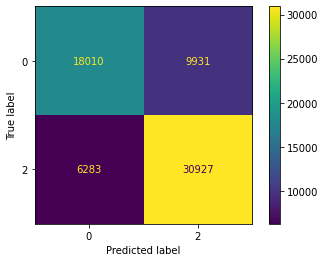

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test1, Y_pred1, labels=xgboost_model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_model1.classes_)
disp.plot()

As we can see, it is a really decent model for its purpose, however, we will also try some other algorithms.

## 3.2. CatBoost

We decided to also try catboost to try to compare its results to the previously obtained results:

In [ ]:
import time
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

#X_train1[cat_cols] = X_train1[cat_cols].astype('category')

catboost_model1 = CatBoostClassifier(random_state = 0, cat_features = cat_cols)

%time catboost_model1.fit(X_train1, Y_train1)

Y_pred1 = catboost_model1.predict(X_test1)    # obtain the test predictions

# F1-score
f1 = f1_score(Y_test1, Y_pred1, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

Learning rate set to 0.097996
0:	learn: 0.6702243	total: 234ms	remaining: 3m 54s
1:	learn: 0.6515227	total: 361ms	remaining: 3m
2:	learn: 0.6370096	total: 536ms	remaining: 2m 58s
3:	learn: 0.6252460	total: 674ms	remaining: 2m 47s
4:	learn: 0.6151693	total: 827ms	remaining: 2m 44s
5:	learn: 0.6074449	total: 947ms	remaining: 2m 36s
6:	learn: 0.6010379	total: 1.11s	remaining: 2m 38s
7:	learn: 0.5957775	total: 1.29s	remaining: 2m 39s
8:	learn: 0.5876984	total: 1.45s	remaining: 2m 40s
9:	learn: 0.5807095	total: 1.6s	remaining: 2m 38s
10:	learn: 0.5754951	total: 1.75s	remaining: 2m 37s
11:	learn: 0.5710216	total: 1.93s	remaining: 2m 38s
12:	learn: 0.5671374	total: 2.1s	remaining: 2m 39s
13:	learn: 0.5642221	total: 2.26s	remaining: 2m 39s
14:	learn: 0.5612489	total: 2.42s	remaining: 2m 38s
15:	learn: 0.5591535	total: 2.57s	remaining: 2m 38s
16:	learn: 0.5573623	total: 2.74s	remaining: 2m 38s
17:	learn: 0.5557997	total: 2.92s	remaining: 2m 39s
18:	learn: 0.5543569	total: 3.09s	remaining: 2m 39

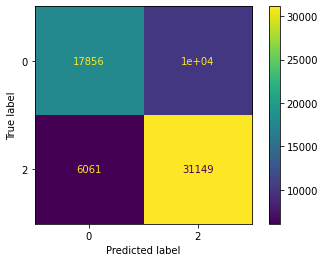

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test1, Y_pred1, labels=catboost_model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model1.classes_)
disp.plot()

Again, it provides a really nice result (slightly worse, but they could be stacked to provide a better result).

## 3.3. LightGBM

We also decided to apply LightGBM, so as to compare with the previous 2 models:

In [ ]:
from lightgbm import LGBMClassifier

lgbm_model1 = LGBMClassifier()
lgbm_model1.fit(X_train1, Y_train1)
Y_pred1 = lgbm_model1.predict(X_test1)

# F1-score
f1 = f1_score(Y_test1, Y_pred1, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

F1 score:     0.7070


The default model gives a really bad result, let us see if it improves with the optimal hyperparameters obtained with optuna:

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

def objective(trial):
  param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 64, 2048),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
        'random_state': trial.suggest_categorical('random_state', [2020]),
    }

  model = LGBMClassifier(**param_grid)
  model.fit(X_train1, Y_train1)
  Y_pred = model.predict(X_test1)
  return f1_score(Y_pred, Y_test1, average = 'micro')

In [ ]:
import optuna

# CODE FROM https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.samplers.TPESampler.html
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=1000, n_jobs = -1, show_progress_bar = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-11 08:34:52,136] A new study created in memory with name: no-name-27153e57-9f78-4150-9477-e82c48b6bd23
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2022-12-11 08:35:01,923] Trial 0 finished with value: 0.6497828122361897 and parameters: {'n_estimators': 437, 'learning_rate': 0.20088573151749586, 'num_leaves': 1260, 'max_depth': 11, 'min_data_in_leaf': 10000, 'max_bin': 219, 'lambda_l1': 60, 'lambda_l2': 45, 'min_gain_to_split': 11.662817012013214, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9, 'random_state': 2020}. Best is trial 0 with value: 0.6497828122361897.
[I 2022-12-11 08:35:17,637] Trial 1 finished with value: 0.6805728231339504 and parameters: {'n_estimators': 1375, 'learning_rate': 0.25766299870029147, 'num_leaves': 160, 'max_depth': 8, 'min_data_in_leaf': 7800, 'max_bin': 231, 'lambda_l1': 10, 'lambda_l2': 5, 'min_gain_to_split': 2.973222002024834, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5, 'random_state': 2020}. Best is trial 1 with value: 0.6805728231339504.
[I 2022-12-11 08:35:44,214] Trial 2 finished with value: 0.664026645792083 and parameters: {'n

Let us build such model:

In [ ]:
from lightgbm import LGBMClassifier

params = {'n_estimators': 1564, 'learning_rate': 0.2067288615286586, 'num_leaves': 1060, 'max_depth': 6, 'min_data_in_leaf': 400, 'max_bin': 207, 'lambda_l1': 15, 'lambda_l2': 55, 'min_gain_to_split': 0.012316395306353327, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.8, 'random_state': 2020}

lgbm_model1 = LGBMClassifier(**params)
lgbm_model1.fit(X_train1, Y_train1)
Y_pred1 = lgbm_model1.predict(X_test1)

# F1-score
f1 = f1_score(Y_test1, Y_pred1, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

F1 score:     0.7371


As we can see, it is remarkably worse than the previous one, so we will not be using it for the competition.

## 3.4. Stacked model

We decided to create a stacked model of CatBoost and XGBoost to improve their performance. Sklearn's StackingClassifier did not allow us to predict with models already trained, so we decided to develop our own algorithm:

In [ ]:
def stacked_boosted_model_initial(test_data):
  #model_stack = [catboost_model1, xgboost_model1, lgbm_model1]
  model_stack = [catboost_model1, xgboost_model1]
  y_pred_stack = []

  test_data = test_data[selected_features1]

  for index in test_data.index:
    pd1, pd2 = (0, 0)

    for model_instance in model_stack:
      computed_proba = model_instance.predict_proba(test_data.loc[[index]])
      pd1 += computed_proba[0][0]
      pd2 += computed_proba[0][1]

    if pd1 >= pd2:
      y_pred_stack.append(0)
    else:
      y_pred_stack.append(2)

  return y_pred_stack

Let us test the stacked model:

In [ ]:
Y_pred1 = stacked_boosted_model_initial(X_test1)

# F1-score
f1 = f1_score(Y_test1, Y_pred1, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

F1 score:     0.7544


As we can see, the results are actually great, so we can keep this stacked model as the final model for the phase 1.

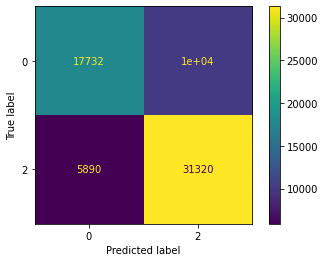

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test1, Y_pred1, labels=catboost_model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model1.classes_)
disp.plot()

# 4. Phase 2

For the second phase, we will perform the exact same approach, by building multiple models, comparing and stacking them if necessary, so as to obtain the best possible results.

## 4.1. CatBoost 

We decided to try CatBoost as the initial algorithm:

In [ ]:
import time
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

catboost_model2 = CatBoostClassifier(random_state = 0, cat_features = cat_cols)

%time catboost_model2.fit(X_train2, Y_train2)

Y_pred2 = catboost_model2.predict(X_test2)    # obtain the test predictions

# F1-score
f1 = f1_score(Y_test2, Y_pred2, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

Learning rate set to 0.068417
0:	learn: 0.6060750	total: 115ms	remaining: 1m 54s
1:	learn: 0.5242821	total: 209ms	remaining: 1m 44s
2:	learn: 0.4631023	total: 284ms	remaining: 1m 34s
3:	learn: 0.4167202	total: 379ms	remaining: 1m 34s
4:	learn: 0.3735703	total: 474ms	remaining: 1m 34s
5:	learn: 0.3413555	total: 564ms	remaining: 1m 33s
6:	learn: 0.3154489	total: 656ms	remaining: 1m 33s
7:	learn: 0.2939679	total: 739ms	remaining: 1m 31s
8:	learn: 0.2770112	total: 851ms	remaining: 1m 33s
9:	learn: 0.2609000	total: 937ms	remaining: 1m 32s
10:	learn: 0.2489353	total: 1.02s	remaining: 1m 31s
11:	learn: 0.2399219	total: 1.1s	remaining: 1m 30s
12:	learn: 0.2309950	total: 1.19s	remaining: 1m 30s
13:	learn: 0.2228646	total: 1.29s	remaining: 1m 31s
14:	learn: 0.2167251	total: 1.37s	remaining: 1m 29s
15:	learn: 0.2111714	total: 1.43s	remaining: 1m 28s
16:	learn: 0.2053427	total: 1.53s	remaining: 1m 28s
17:	learn: 0.2012224	total: 1.6s	remaining: 1m 27s
18:	learn: 0.1969560	total: 1.71s	remaining: 1

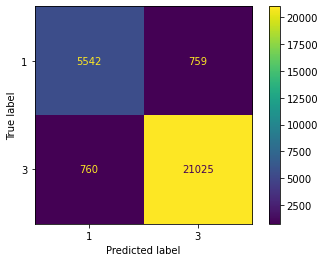

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test2, Y_pred2, labels=catboost_model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model2.classes_)
disp.plot()

As we can see, we hit almost 95% of f1-score, which makes sense because damage grades 1 and 3 should be really different.

## 4.2. XGBoost

We also decided to apply XGBoost to obtain a prediction. We use optuna for hyperparameter tuning:

In [ ]:
import optuna


from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 64, 4096),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'n_jobs' : -1,
        'tree_method' : 'gpu_hist'
    }

    model = XGBClassifier(**param)

    %time model.fit(X_train2, Y_train2)

    Y_pred = model.predict(X_test2)    # obtain the test predictions

    # F1-score
    return f1_score(Y_test2, Y_pred, average = 'micro')

In [ ]:
# CODE FROM https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.samplers.TPESampler.html
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs = -1, show_progress_bar = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-11 17:45:11,135] A new study created in memory with name: no-name-2d86c979-3030-46a8-8d7c-bb178def0d16
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-26-11bdeca29363>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
<ipython-input-26-11bdeca29363>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


XGBoostError: ignored

XGBoostError: ignored

[W 2022-12-11 17:45:11,388] Trial 0 failed because of the following error: XGBoostError('need to call fit or load_model beforehand')
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-26-11bdeca29363>", line 26, in objective
    Y_pred = model.predict(X_test2)    # obtain the test predictions
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 788, in predict
    class_probs = self.get_booster().predict(test_dmatrix,
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 193, in get_booster
    raise XGBoostError('need to call fit or load_model beforehand')
xgboost.core.XGBoostError: need to call fit or load_model beforehand
[W 2022-12-11 17:45:11,394] Trial 1 failed because of the following error: XGBoostError('need to call fit or load_model beforehand')
Traceback (most recent call last):
  File "/usr/local/l

XGBoostError: ignored

Let us build the optimal model:

In [ ]:
import time
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

params = {'lambda': 0.015759683901760288, 'alpha': 2.513705830702151, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 3547, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 6, 'random_state' : 2020}


xgboost_model2 = XGBClassifier(**params)

%time xgboost_model2.fit(X_train2, Y_train2)

Y_pred2 = xgboost_model2.predict(X_test2)    # obtain the test predictions

# F1-score
f1 = f1_score(Y_test2, Y_pred2, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

CPU times: user 11min 23s, sys: 1.15 s, total: 11min 24s
Wall time: 11min 26s
F1 score:     0.9444


As we can see, we obtain a high f1-score again, so both models look to work fine.

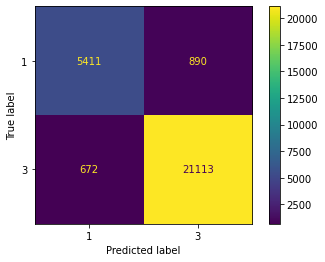

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test2, Y_pred2, labels=catboost_model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model2.classes_)
disp.plot()

## 4.3. LightGBM

We also decided to try with LightGBM to compare the results:

In [ ]:
from lightgbm import LGBMClassifier

lgbm_model2 = LGBMClassifier()
lgbm_model2.fit(X_train2, Y_train2)
Y_pred2 = lgbm_model2.predict(X_test2)

# F1-score
f1 = f1_score(Y_test2, Y_pred2, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

F1 score:     0.9275


The initial value is decent, let us try to optimize it with optuna:

In [ ]:
def objective(trial):
  param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 64, 2048),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
        'random_state': trial.suggest_categorical('random_state', [2020]),
    }

  model = LGBMClassifier(**param_grid)
  model.fit(X_train2, Y_train2)
  Y_pred = model.predict(X_test2)
  return f1_score(Y_pred, Y_test2, average = 'micro')

In [ ]:
import optuna
# CODE FROM https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.samplers.TPESampler.html
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=200, n_jobs = -1, show_progress_bar = True)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-10 20:28:38,910] A new study created in memory with name: no-name-36a5dc79-a6e7-4150-b4ff-82650b2debbe
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-12-10 20:28:42,073] Trial 1 finished with value: 0.8955351420636616 and parameters: {'n_estimators': 304, 'learning_rate': 0.16797867881267525, 'num_leaves': 460, 'max_depth': 5, 'min_data_in_leaf': 9800, 'max_bin': 273, 'lambda_l1': 85, 'lambda_l2': 15, 'min_gain_to_split': 0.8875370717984848, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2, 'random_state': 2020}. Best is trial 1 with value: 0.8955351420636616.
[I 2022-12-10 20:28:50,907] Trial 0 finished with value: 0.8974578081606495 and parameters: {'n_estimators': 1254, 'learning_rate': 0.050164382026069564, 'num_leaves': 2600, 'max_depth': 4, 'min_data_in_leaf': 6400, 'max_bin': 214, 'lambda_l1': 75, 'lambda_l2': 45, 'min_gain_to_split': 9.373737653039864, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7, 'random_state': 2020}. Best is trial 0 with value: 0.8974578081606495.
[I 2022-12-10 20:28:53,483] Trial 3 finished with value: 0.8440504165776543 and parameters: {'n_estimators': 2

Let us build the model:

In [ ]:
from lightgbm import LGBMClassifier

params = {'n_estimators': 1191, 'learning_rate': 0.1426728690827209, 'num_leaves': 3000, 'max_depth': 12, 'min_data_in_leaf': 800, 'max_bin': 269, 'lambda_l1': 5, 'lambda_l2': 65, 'min_gain_to_split': 0.04064992740078566, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.8, 'random_state': 2020}

lgbm_model2 = LGBMClassifier(**params)
lgbm_model2.fit(X_train2, Y_train2)
Y_pred2 = lgbm_model2.predict(X_test2)

# F1-score
f1 = f1_score(Y_test2, Y_pred2, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

F1 score:     0.9395


As we can see, the result is worse than the previous algorithms:

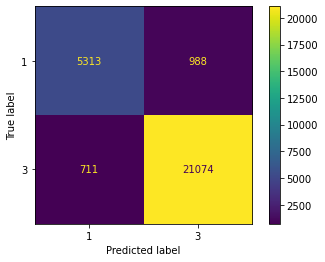

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test2, Y_pred2, labels=lgbm_model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm_model2.classes_)
disp.plot()

## 4.4. Stacked model

Again, we decided to combine XGBoost and CatBoost models to obtain the highest possible result. Since Sklearn's StackingClassifier does not let us use our already trained model, we decided to create our own algorithm:

In [ ]:
def stacked_boosted_model_final(test_data):
  #model_stack = [catboost_model2, xgboost_model2, lgbm_model2]
  model_stack = [catboost_model2, xgboost_model2]
  y_pred_stack = []

  test_data = test_data[selected_features2]

  for index in test_data.index:
    pd1, pd2 = (0, 0)

    for model_instance in model_stack:
      computed_proba = model_instance.predict_proba(test_data.loc[[index]])
      pd1 += computed_proba[0][0]
      pd2 += computed_proba[0][1]

    if pd1 >= pd2:
      y_pred_stack.append(1)
    else:
      y_pred_stack.append(3)

  return y_pred_stack

Let's test the stacked model:

In [ ]:
Y_pred2 = stacked_boosted_model_final(X_test2)

# F1-score
f1 = f1_score(Y_test2, Y_pred2, average = 'micro')
print('F1 score: ' + '{:10.4f}'.format(f1))

F1 score:     0.9464


Again, it looks to work really good (better than the individual algorithms):

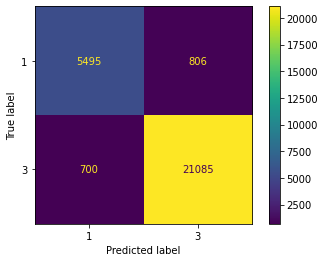

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test2, Y_pred2, labels=catboost_model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost_model2.classes_)
disp.plot()

# 5. Competition results

Let us obtain the result of our 2 models in the competition:

In [ ]:
prediction_1 = stacked_boosted_model_initial(test_values[selected_features1])
test_values['prediction'] = prediction_1
prediction_2 = stacked_boosted_model_final(test_values[selected_features2].loc[test_values['prediction'] == 0])
test_values['prediction'].loc[test_values['prediction'] == 0] = prediction_2

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# create the submission file
xgboost_submission = pd.DataFrame(data=test_values['prediction'].to_numpy(),
                             columns=submission_format.columns, # only one column: 'damage_grade' 
                             index=submission_format.index)
xgboost_submission.to_csv('two_phase.csv')

With this model, we were able to obtain 0.7438, with which we obtained the rank 459 in the competition, our highest value for the whole project.